# Level Truncation in String Field Theory

H. Erbin, R. Finotello, M. Kudrna

## Minimal Models

We consider minimal models in String Field Theory and their truncation levels.
We use machine learning techniques to extrapolate the value of the truncations $L$ at $\infty$ given the results using fits of polynomials in $\frac{1}{L}$.

## Deep Learning Analysis

We use the previously created notebook to predict the boundary state extrapolations using deep learning techniques.
Specifically we use *Tensorflow* and *Keras* to build different architectures.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import re
import gzip
import csv
import tqdm
import time
from datetime import datetime
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
sns.set()
ratio   = lambda x, y: (6 * y, 5 * x)

os.makedirs('./img', exist_ok=True)
os.makedirs('./models', exist_ok=True)

In [4]:
def savefig(filename, fig, show=False):
    '''
    Save a Matplotlib figure to file.
    
    Needed arguments:
        filename: the path to the saved file in the img directory (no extension),
        fig:      the Matplotlib figure object.
        
    Optional arguments:
        show: show the plot inline (bool).
    '''
    
    # save the figure to file (PDF and PNG)
    fig.tight_layout()
    fig.savefig(os.path.join('./img', filename + '.pdf'), dpi=144, format='pdf')
    fig.savefig(os.path.join('./img', filename + '.png'), dpi=144, format='png')
    
    # show if interactive
    if show:
        plt.show()
    
    # release memory
    fig.clf()
    plt.close(fig)

In [5]:
random_state = 123
np.random.seed(random_state)
tf.random.set_seed(random_state)

## Load the Dataset

We use the pruned dataset created at the end of the [**exploratory data analysis**](./minimal-models_eda.ipynb).
We first load the JSON dataset containing the samples.
We then divide it into 80% training samples, 10% validation and 10% test.
We then write each fold into separate CSV files and load them using a generator.

In [6]:
df = pd.read_json('./data/data_ml.json.gz', orient='records')

In [7]:
# take 80% for training
train_ratio = 0.8
df_train = df.sample(frac=train_ratio, random_state=random_state)
df_oos   = df.loc[~df.index.isin(df_train.index)]

n_train = df_train.shape[0]

# take 10% for validation (50% of what remains from training)
df_val   = df_oos.sample(frac=0.5, random_state=random_state)
df_test  = df_oos.loc[~df_oos.index.isin(df_val.index)].copy()

n_val  = df_val.shape[0]
n_test = df_test.shape[0]

# check that the shapes are ok
assert n_train + n_val + n_test == df.shape[0]

In [8]:
# save the input shape for later use (NB: -1 for the labels, -2 for solution and observable columns)
features_shape = (df_train.shape[1] - 1 - 2,)

## Analysis of the Features

As a reference we compute statistics of the features of the training set.
We then proceed with normalisation.

In [9]:
df_train.filter(regex='^lev_[0-9][0-9]$').describe()

,lev_02,lev_03,lev_04,lev_05,lev_06,lev_07,lev_08,lev_09,lev_10,lev_11,lev_12,lev_13,lev_14,lev_15,lev_16
count,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000
mean,0.054294,0.043125,0.740809,0.835809,-1.500595,-1.687148,4.349825,4.744879,-9.175973,-9.942949,20.455175,21.959602,-40.099910,-42.887507,76.175352
std,2.241358,2.772814,8.368538,9.253320,21.592071,22.788109,54.514555,56.616838,141.175299,145.790545,365.430714,375.775269,890.783228,913.498132,2011.586621
min,-16.510461,-19.052532,-67.734861,-73.752143,-153.591878,-158.215607,-375.159011,-398.506858,-1019.836200,-1056.973997,-3088.571225,-3202.704999,-7214.470476,-7360.544373,-19507.330644
25%,-0.312328,-0.364791,-0.299228,-0.210539,-0.259597,-0.292002,-0.309998,-0.204919,-0.275902,-0.310851,-0.267158,-0.187466,-0.277082,-0.315323,-0.264248
50%,0.187957,0.260716,0.256796,0.273184,0.270108,0.283561,0.234981,0.277937,0.290469,0.284952,0.250427,0.292627,0.284037,0.277707,0.254025
75%,0.752034,0.832662,0.807046,0.810501,0.782033,0.849615,0.821877,0.812907,0.822950,0.835495,0.835060,0.847161,0.834103,0.823959,0.831059
max,14.298479,19.543429,78.213480,86.527048,129.905809,137.018735,401.749230,411.917281,1080.829182,1132.462512,2770.517946,2858.492005,8134.783092,8380.547417,17641.456613


In [10]:
df_train.filter(regex='^lev_.*_lev_[0-9][0-9]$').describe()

,lev_03_lev_02,lev_04_lev_03,lev_05_lev_04,lev_06_lev_05,lev_07_lev_06,lev_08_lev_07,lev_09_lev_08,lev_10_lev_09,lev_11_lev_10,lev_12_lev_11,lev_13_lev_12,lev_14_lev_13,lev_15_lev_14,lev_16_lev_15
count,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000
mean,-0.011168,0.697683,0.095001,-2.336404,-0.186553,6.036973,0.395054,-13.920852,-0.766977,30.398124,1.504427,-62.059512,-2.787597,119.062859
std,1.101292,10.749048,1.984573,30.306050,2.932579,76.652052,5.604988,197.398977,10.904367,510.090420,20.736085,1264.873759,38.489764,2922.736791
min,-10.566483,-84.234838,-33.710558,-235.163947,-29.397166,-510.725626,-36.692103,-1405.853685,-139.095202,-4221.033736,-114.133774,-9882.200355,-465.891321,-27887.878061
25%,-0.031302,-0.059758,-0.016548,-0.011217,-0.003746,-0.011264,-0.004758,-0.003953,-0.001341,-0.004806,-0.002306,-0.001933,-0.000746,-0.002587
50%,-0.004306,-0.005133,-0.001458,-0.001397,-0.000249,-0.000920,-0.000313,-0.000382,-0.000058,-0.000352,-0.000106,-0.000153,-0.000030,-0.000195
75%,0.066236,0.026364,0.013293,0.032141,0.007739,0.004693,0.003166,0.008824,0.002967,0.001747,0.001447,0.004257,0.001433,0.000949
max,13.172590,97.266012,15.899676,203.657952,38.445042,559.599410,68.938027,1479.336040,51.633330,3827.491943,264.217294,11337.488091,245.764325,25002.000987


In [11]:
df_train.filter(regex='^lev_[0-9][0-9]_x_weight$').describe()

,lev_02_x_weight,lev_03_x_weight,lev_04_x_weight,lev_05_x_weight,lev_06_x_weight,lev_07_x_weight,lev_08_x_weight,lev_09_x_weight,lev_10_x_weight,lev_11_x_weight,lev_12_x_weight,lev_13_x_weight,lev_14_x_weight,lev_15_x_weight,lev_16_x_weight
count,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000
mean,-0.676837,-0.821723,2.725832,3.053518,-8.362252,-9.020064,20.101085,21.504550,-45.924389,-48.670839,99.403983,104.763152,-199.113222,-209.035902,376.546554
std,9.856716,11.578771,41.099597,44.713422,107.158225,112.534124,271.982954,281.904117,705.167856,727.552732,1826.630945,1877.586330,4453.340408,4566.098819,10057.490427
min,-82.552307,-95.262659,-338.674305,-368.760714,-767.959388,-791.078034,-1875.795056,-1992.534288,-5099.181001,-5284.869984,-15442.856125,-16013.524993,-36072.352380,-36802.721867,-97536.653220
25%,-0.082030,-0.053750,-0.066441,-0.031395,-0.050466,-0.044295,-0.070762,-0.027565,-0.027580,-0.043530,-0.043627,-0.023534,-0.029129,-0.045367,-0.030486
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.097706,0.171381,0.169374,0.185518,0.167317,0.189635,0.144747,0.199159,0.203786,0.202428,0.149484,0.218234,0.194663,0.180321,0.178881
max,71.492395,82.499883,391.067402,432.635242,649.529047,685.093674,2008.746152,2059.586406,5404.145909,5662.312558,13852.589730,14292.460023,40673.915461,41902.737086,88207.283066


In [12]:
df_train.filter(regex='^lev_.*_lev.*_x_weight$').describe()

,lev_03_lev_02_x_weight,lev_04_lev_03_x_weight,lev_05_lev_04_x_weight,lev_06_lev_05_x_weight,lev_07_lev_06_x_weight,lev_08_lev_07_x_weight,lev_09_lev_08_x_weight,lev_10_lev_09_x_weight,lev_11_lev_10_x_weight,lev_12_lev_11_x_weight,lev_13_lev_12_x_weight,lev_14_lev_13_x_weight,lev_15_lev_14_x_weight,lev_16_lev_15_x_weight
count,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000
mean,-0.144885,3.547555,0.327686,-11.415770,-0.657811,29.121149,1.403465,-67.428940,-2.746450,148.074822,5.359169,-303.876374,-9.922679,585.582455
std,3.046550,52.165568,6.423678,150.009429,10.262359,381.837749,19.722088,985.714652,38.997447,2549.326620,77.145618,6323.406437,151.395890,14612.894522
min,-33.208946,-421.174188,-105.947469,-1175.819735,-107.030250,-2553.628130,-116.739232,-7029.268425,-437.156348,-21105.168682,-570.668869,-49411.001775,-1464.229865,-139439.390306
25%,-0.001820,-0.014503,-0.002181,-0.000552,-0.000291,-0.002324,-0.000893,-0.000241,-0.000110,-0.000778,-0.000471,-0.000109,-0.000065,-0.000477
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.036629,0.003518,0.002063,0.011301,0.002199,0.000557,0.000493,0.002978,0.000918,0.000184,0.000213,0.001417,0.000393,0.000094
max,41.399567,486.330061,52.227851,1018.289761,120.827275,2797.997051,216.662369,7396.680198,258.166649,19137.459715,830.397211,56687.440454,1228.821625,125010.004933


## Normalisation of the Features

We scale the features to the interval $[0,\, 1]$ to improve scalability of the deep learning technique:

In [13]:
norm_cols    = [c for c in df_train.columns if re.match('^lev_', c)]
min_max_cols = [(c, np.min(df_train[c]), np.max(df_train[c])) for c in norm_cols]

# apply the transformation
for c, m, M in min_max_cols:
    df_train[c] = df_train[c].apply(lambda x: (x - m) / (M - m))
    df_val[c]   = df_val[c].apply(lambda x: (x - m) / (M - m))
    df_test[c]  = df_test[c].apply(lambda x: (x - m) / (M - m))

We write to CSV files the three folds:

In [14]:
df_train.to_csv('./data/train.csv.gz', index=False)
df_val.to_csv('./data/val.csv.gz', index=False)
df_test.to_csv('./data/test.csv.gz', index=False)

## Creating the Dataset

We then separate features from labels and convert to a *Tensorflow* dataset:

In [15]:
def csv_generator(file, n_rows=-1, skip_rows=1, skip_columns=0, delimiter=','):
    '''
    Read a CSV file and build a generator (last column is the label).
    
    Needed arguments:
        file: the path to the CSV file.
        
    Optional arguments:
        n_rows:       read up to n_rows unless -1 (read to the end),
        skip_rows:    number of rows to skip at the beginning,
        skip_columns: number of columns to skip on the left,
        delimiter:    type of delimiter.
    '''
    
    # handle gzipped files
    if '.gz' in file:
        op = lambda s: gzip.open(s, 'rt')
    else:
        op = lambda s: open(s, 'r')
        
    # open and read
    with op(file) as f:
        data = csv.reader(f, delimiter=delimiter)
        if n_rows == -1:
            for i, row in enumerate(data):
                if i >= skip_rows:
                    yield (np.array(row[skip_columns:-1]), row[-1])
        if n_rows > skip_rows:
            for i, row in enumerate(data):
                if i >= skip_rows and i <= n_rows:
                    yield (np.array(row[skip_columns:-1]), row[-1])
        if 0 <= n_rows <= skip_rows:
            print('n_rows should be > than skip_rows or -1.')

In [16]:
data = {'train': lambda: csv_generator('./data/train.csv.gz', skip_columns=2),
        'val':   lambda: csv_generator('./data/val.csv.gz', skip_columns=2),
        'test':  lambda: csv_generator('./data/test.csv.gz', skip_columns=2)
       }

# create datasets
train = tf.data.Dataset.from_generator(data['train'], (np.float32, np.float32), output_shapes=(features_shape, ()))
val   = tf.data.Dataset.from_generator(data['val'], (np.float32, np.float32), output_shapes=(features_shape, ()))
test  = tf.data.Dataset.from_generator(data['test'], (np.float32, np.float32), output_shapes=(features_shape, ()))

We then create a working directory to save models and weights:

In [17]:
# save the model into the appropriate directory
now     = datetime.now().strftime("%d%m%Y_%H%M%S")
now_dir = 'fc_' + now
now_dir = os.path.join('./models', now_dir)
os.makedirs(now_dir)
print(f'Current working directory: {now_dir}')

Current working directory: ./models/fc_14122020_170616


## Deep Learning - Fully Connected

We finally move to the construction of the deep learning model using *Keras*.
We first focus on fully connected layers.

In [18]:
def fc_model(layers,
             input_shape=(3,),
             activation='relu',
             leaky_relu=0.0,
             batch_norm=False,
             dropout=0.0,
             l1_reg=0.0,
             l2_reg=0.0,
             random_state=123,
             name='fc_model'
            ):
    '''
    Build a fully connected model.
    
    Needed arguments:
        layers:      list of units per layer (list),
        input_shape: shape of the input (tuple or int).
        
    Optional arguments:
        activation:    type of activation (can be a Tensorflow object if custom),
        leaky_relu:    slope of the LeakyReLU activation (float),
        batch_norm:    use batch normalisation,
        dropout:       dropout rate,
        l1_reg:        l1 regularisation factor,
        l2_reg:        l2 regularisation factor,
        random_state:  the random seed,
        name:          name of the model.
        
    Returns:
        a Keras model.
    '''
    
    # initialise Keras
    keras.backend.clear_session()
    
    # handle input shape
    if isinstance(input_shape, float):
        input_shape = (input_shape,)
        
    # build regularizer
    if l2_reg == 0.0:
        regularizer = keras.regularizers.l1(l1_reg)
    elif l1_reg == 0.0:
        regularizer = keras.regularizers.l2(l2_reg)
    else:
        regularizer = keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
    
    # build the model
    I = keras.Input(shape=input_shape, name=name + '_input')
    x = I
    
    for i, units in enumerate(layers):
        x = keras.layers.Dense(units,
                               activity_regularizer=regularizer,
                               kernel_initializer=keras.initializers.glorot_uniform(random_state),
                               bias_initializer=keras.initializers.zeros(),
                               name=name + '_dense_' + str(i)
                              )(x)
        if 'square':
            x = tf.square(x)
        elif activation == 'leakyrelu':
            x = keras.layers.LeakyReLU(alpha=leaky_relu, name=name + '_act_' + str(i))(x)
        else:
            x = keras.layers.Activation(activation)(x)
        if batch_norm:
            x = keras.layers.BatchNormalization(name=name + '_bnorm_' + str(i))(x)
        if dropout > 0.0:
            x = keras.layers.Dropout(rate=dropout, seed=random_state, name=name + '_dout_' + str(i))(x)
            
    O = keras.layers.Dense(1,
                           kernel_initializer=keras.initializers.glorot_uniform(random_state),
                           bias_initializer=keras.initializers.zeros(),
                           name=name + '_output'
                          )(x)
    
    model = keras.Model(inputs=I, outputs=O, name=name)
    
    return model

In [19]:
def fit_model(model,
              train_data,
              val_data=None,
              epochs=10,
              batch_size=None,
              learning_rate=1.0e-3,
              verbose=1
             ):
    '''
    Fit a Keras model.
    
    Needed arguments:
        model:      the model to train,
        train_data: the Tensorflow dataset for training.
        
    Optional arguments:,
        val_data:      the Tensorflow dataset for validation,
        epochs:        number of training epochs,
        batch_size:    the size of the mini batch,
        learning_rate: the shrinking parameter,
        verbose:       verbosity level.
        
    Returns:
        the Keras model, a History object.
    '''
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mse', 'mae']
                 )
    history = model.fit(x=train_data,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=verbose,
                        callbacks=[keras.callbacks.ModelCheckpoint(os.path.join(now_dir, model.name + '.h5'),
                                                                   monitor='val_loss' if val_data is not None else 'loss',
                                                                   verbose=verbose,
                                                                   save_best_only=True
                                                                  ),
                                   keras.callbacks.ReduceLROnPlateau(monitor='val_loss' if val_data is not None else 'loss',
                                                                     factor=0.3,
                                                                     patience=int(epochs / 4),
                                                                     verbose=verbose,
                                                                     min_lr=1.0e-6
                                                                    )
                                  ],
                        validation_data=val_data
                       )

    return model, history

We then move to defining the model:

In [20]:
# parameters of the model
model_data = {'layers':      [64, 64, 128, 128, 256, 256, 64, 64, 32],
              'input_shape': features_shape,
              'activation':  'square',
              'leaky_relu':  0.0,
              'batch_norm':  True,
              'dropout':     0.01,
              'l1_reg':      1.0e-4,
              'l2_reg':      1.0e-4
             }

In [21]:
# compute the number of parameters
layer_shapes     = [features_shape[0]] + model_data['layers'] + [1]
dense_parameters = [(layer_shapes[n] + 1) * layer_shapes[n+1] for n in range(len(layer_shapes)-1)]
bnorm_parameters = {'total':     [units * 4 for units in model_data['layers']],
                    'trainable': [units * 2 for units in model_data['layers']]
                   }

parameters = {k: np.sum(dense_parameters) + np.sum(v) for k, v in bnorm_parameters.items()}
print(f'Total parameters:         {parameters["total"]:d}')
print(f'Trainable parameters:     {parameters["trainable"]:d}')
print(f'Non trainable parameters: {parameters["total"] - parameters["trainable"]:d}')

Total parameters:         158593
Trainable parameters:     156481
Non trainable parameters: 2112


In [22]:
# parameters of the fitting function
fit_data = {'epochs':        500,
            'learning_rate': 1.0e-3,
            'verbose':       0
           }

# size of the mini batches
batch_size = 32

In [23]:
# parameters to gather statistics
stat_data = {'step':    0.2,
             'average': 3
            }

Finally we can fit the model:

In [24]:
# sample sizes
sample_sizes = np.arange(stat_data['step'], 1.0 + stat_data['step'], stat_data['step'])
train_sizes  = [int(n_train * s) for s in sample_sizes]

# history (train_ratio x epochs x random_seeds)
training_data = {'train_loss': np.zeros((len(train_sizes), fit_data['epochs'], stat_data['average'])),
                 'val_loss': np.zeros((len(train_sizes), fit_data['epochs'], stat_data['average'])),
                 'train_mse': np.zeros((len(train_sizes), fit_data['epochs'], stat_data['average'])),
                 'train_mae': np.zeros((len(train_sizes), fit_data['epochs'], stat_data['average'])),
                 'val_mse': np.zeros((len(train_sizes), fit_data['epochs'], stat_data['average'])),
                 'val_mae': np.zeros((len(train_sizes), fit_data['epochs'], stat_data['average'])),
                 'epoch_times': np.zeros((len(train_sizes), fit_data['epochs'], stat_data['average'])),
                 'lr': np.zeros((len(train_sizes), fit_data['epochs'], stat_data['average'])),
                 'random_states': np.random.randint(len(train_sizes) * fit_data['epochs'] * stat_data['average'],
                                                    size=(len(train_sizes), stat_data['average'])
                                                   )
                }

# predictions and residuals (train_ratio x set_size x random_seeds)
predictions = {'training':   np.zeros((len(train_sizes), n_train, stat_data['average'])),
               'validation': np.zeros((len(train_sizes), n_val, stat_data['average'])),
               'test':       np.zeros((len(train_sizes), n_test, stat_data['average']))
              }

# evaluations for loss, MSE and MAE (train_ratio x 3 x random_seeds)
evaluations = {'training':   np.zeros((len(train_sizes), 3, stat_data['average'])),
               'validation': np.zeros((len(train_sizes), 3, stat_data['average'])),
               'test':       np.zeros((len(train_sizes), 3, stat_data['average']))
              }

# training loop
for t, size in enumerate(train_sizes):
    
    # print status
    print(f'\nTraining size: {size:d} samples ({int(100 * sample_sizes[t]):d}% of the training set).', flush=True)
    
    # select subsample
    train_batches = train.take(size).batch(batch_size).prefetch(2)
    val_batches   = val.batch(n_val).prefetch(1)
    test_batches  = test.batch(n_test).prefetch(1)

    # loop over random seeds
    for seed in range(stat_data['average']):
        
        # print status
        print(f'\n  Training model with random seed {seed:d}...')
        print(f'  Training model {t * stat_data["average"] + (seed + 1):d} / {len(train_sizes) * stat_data["average"]:d}...\n')
        start = time.time()
        print(f'    Start: {time.strftime("%d/%m/%Y %H:%M:%S", time.gmtime(start))}', flush=True)

        # set new random seed
        random_state = training_data['random_states'][t,seed]
        np.random.seed(random_state)
        tf.random.set_seed(random_state)

        # create the model
        model = fc_model(name=f'fc_s{sample_sizes[t]:.2f}_rs{seed:d}', random_state=random_state, **model_data)
        
        # fit the model
        model, history = fit_model(model, train_data=train_batches, val_data=val_batches, **fit_data)
        model = keras.models.load_model(os.path.join(now_dir, model.name + '.h5'))
        
        # store the data
        print(f'    Storing training data...', flush=True)
        training_data['train_loss'][t,:,seed]  = history.history['loss']
        training_data['val_loss'][t,:,seed]    = history.history['val_loss']
        training_data['train_mse'][t,:,seed]   = history.history['mse']
        training_data['val_mse'][t,:,seed]     = history.history['val_mse']
        training_data['train_mae'][t,:,seed]   = history.history['mae']
        training_data['val_mae'][t,:,seed]     = history.history['val_mae']
        training_data['lr'][t,:,seed]          = history.history['lr']
        
        # compute the predictions
        print(f'    Computing predictions...', flush=True)
        train_preds = model.predict(train_batches)
        predictions['training'][t,:,seed]   = np.pad(np.reshape(train_preds, (-1,)), (0, n_train - train_preds.shape[0]))
        predictions['validation'][t,:,seed] = np.reshape(model.predict(val_batches), (-1,))
        predictions['test'][t,:,seed]       = np.reshape(model.predict(test_batches), (-1,))
        
        # evaluate the model
        print(f'    Evaluating the model...', flush=True)
        evaluations['training'][t,:,seed]   = model.evaluate(train_batches, verbose=0)
        evaluations['validation'][t,:,seed] = model.evaluate(val_batches, verbose=0)
        evaluations['test'][t,:,seed]       = model.evaluate(test_batches, verbose=0)
        
        # stop training
        stop  = time.time()
        training_data['epoch_times'][t,:,seed] = stop - start
        print(f'    Stop:  {time.strftime("%d/%m/%Y %H:%M:%S", time.gmtime(stop))}', flush=True)
        print(f'    Time elapsed: {time.strftime("%H hours, %M minutes, %S seconds", time.gmtime(stop - start))}\n', flush=True)
        
        # print evaluations
        print('    Loss:')
        print(f'     training: {evaluations["training"][t,0,seed]:.4f}')
        print(f'     validation: {evaluations["validation"][t,0,seed]:.4f}')
        print('    MSE:')
        print(f'     training: {evaluations["training"][t,1,seed]:.4f}')
        print(f'     validation: {evaluations["validation"][t,1,seed]:.4f}')
        print('    MAE:')
        print(f'     training: {evaluations["training"][t,2,seed]:.4f}')
        print(f'     validation: {evaluations["validation"][t,2,seed]:.4f}')
        
        
# end of training
print(f'\nEnd of training. Full training time: {time.strftime("%H hours, %M minutes, %S seconds", time.gmtime(np.sum(training_data["epoch_times"])))}')


Training size: 128 samples (20% of the training set).

  Training model with random seed 0...
  Training model 1 / 15...

    Start: 14/12/2020 16:06:16
    Storing training data...
    Computing predictions...
    Evaluating the model...
    Stop:  14/12/2020 16:07:21
    Time elapsed: 00 hours, 01 minutes, 04 seconds

    Loss:
     training: 0.4145
     validation: 0.3441
    MSE:
     training: 0.3960
     validation: 0.3253
    MAE:
     training: 0.5247
     validation: 0.4863

  Training model with random seed 1...
  Training model 2 / 15...

    Start: 14/12/2020 16:07:21
    Storing training data...
    Computing predictions...
    Evaluating the model...
    Stop:  14/12/2020 16:08:24
    Time elapsed: 00 hours, 01 minutes, 03 seconds

    Loss:
     training: 0.4184
     validation: 0.3463
    MSE:
     training: 0.3977
     validation: 0.3255
    MAE:
     training: 0.5258
     validation: 0.4863

  Training model with random seed 2...
  Training model 3 / 15...

    Start

## Analysis of the Results

We plot loss and metrics of the model for evaluation (we only consider the largest training size):

/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


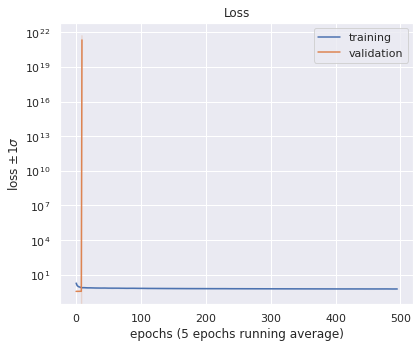

In [25]:
# plot the loss
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))
running_avg = {'train_loss_mean': np.convolve(np.mean(training_data['train_loss'][-1,:,:], axis=1),
                                              np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']), mode='valid'
                                             ),
               'train_loss_std': np.convolve(np.std(training_data['train_loss'][-1,:,:], axis=1),
                                             np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']), mode='valid'
                                            ),
               'val_loss_mean': np.convolve(np.mean(training_data['val_loss'][-1,:,:], axis=1),
                                            np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']), mode='valid'
                                           ),
               'val_loss_std': np.convolve(np.std(training_data['val_loss'][-1,:,:], axis=1),
                                           np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']), mode='valid'
                                          )
              }

sns.lineplot(x=np.arange(running_avg['train_loss_mean'].shape[0]),
             y=running_avg['train_loss_mean'],
             color='C0',
             ax=ax
            )
ax.fill_between(x=np.arange(running_avg['train_loss_mean'].shape[0]),
                y1=running_avg['train_loss_mean'] + running_avg['train_loss_std'],
                y2=running_avg['train_loss_mean'] - running_avg['train_loss_std'],
                color='C0',
                alpha=0.15
               )
sns.lineplot(x=np.arange(running_avg['val_loss_mean'].shape[0]),
             y=running_avg['val_loss_mean'],
             color='C1',
             ax=ax
            )
ax.fill_between(x=np.arange(running_avg['val_loss_mean'].shape[0]),
                y1=running_avg['val_loss_mean'] + running_avg['val_loss_std'],
                y2=running_avg['val_loss_mean'] - running_avg['val_loss_std'],
                color='C1',
                alpha=0.15
               )

ax.set(title='Loss', xlabel=f'epochs ({int(0.01 * fit_data["epochs"]):d} epochs running average)', ylabel='loss $\pm 1\sigma$', yscale='log')
ax.legend(['training', 'validation'])
savefig('fc_loss', fig, show=True)

/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


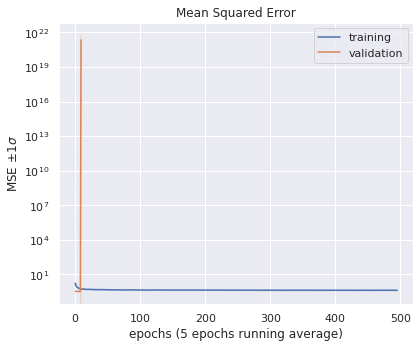

In [26]:
# plot the MSE
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))
running_avg = {'train_mse_mean': np.convolve(np.mean(training_data['train_mse'][-1,:,:], axis=1),
                                             np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']),
                                             mode='valid'
                                            ),
               'train_mse_std': np.convolve(np.std(training_data['train_mse'][-1,:,:], axis=1),
                                            np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']),
                                            mode='valid'
                                           ),
               'val_mse_mean': np.convolve(np.mean(training_data['val_mse'][-1,:,:], axis=1),
                                           np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']),
                                           mode='valid'
                                          ),
               'val_mse_std': np.convolve(np.std(training_data['val_mse'][-1,:,:], axis=1),
                                          np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']),
                                          mode='valid'
                                         )
              }

sns.lineplot(x=np.arange(running_avg['train_mse_mean'].shape[0]),
             y=running_avg['train_mse_mean'],
             color='C0',
             ax=ax
            )
ax.fill_between(x=np.arange(running_avg['train_mse_mean'].shape[0]),
                y1=running_avg['train_mse_mean'] + running_avg['train_mse_std'],
                y2=running_avg['train_mse_mean'] - running_avg['train_mse_std'],
                color='C0',
                alpha=0.15
               )
sns.lineplot(x=np.arange(running_avg['val_mse_mean'].shape[0]),
             y=running_avg['val_mse_mean'],
             color='C1',
             ax=ax
            )
ax.fill_between(x=np.arange(running_avg['val_mse_mean'].shape[0]),
                y1=running_avg['val_mse_mean'] + running_avg['val_mse_std'],
                y2=running_avg['val_mse_mean'] - running_avg['val_mse_std'],
                color='C1',
                alpha=0.15
               )

ax.set(title='Mean Squared Error', xlabel=f'epochs ({int(0.01 * fit_data["epochs"]):d} epochs running average)', ylabel=f'MSE $\pm 1\sigma$', yscale='log')
ax.legend(['training', 'validation'])
savefig('fc_mse', fig, show=True)

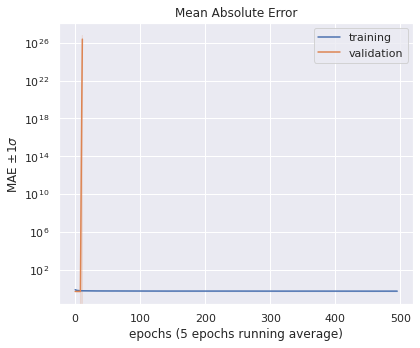

In [27]:
# plot the MAE
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))
running_avg = {'train_mae_mean': np.convolve(np.mean(training_data['train_mae'][-1,:,:], axis=1),
                                             np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']),
                                             mode='valid'
                                            ),
               'train_mae_std': np.convolve(np.std(training_data['train_mae'][-1,:,:], axis=1),
                                            np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']),
                                            mode='valid'
                                           ),
               'val_mae_mean': np.convolve(np.mean(training_data['val_mae'][-1,:,:], axis=1),
                                           np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']),
                                           mode='valid'
                                          ),
               'val_mae_std': np.convolve(np.std(training_data['val_mae'][-1,:,:], axis=1),
                                          np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']),
                                          mode='valid'
                                         )
              }

sns.lineplot(x=np.arange(running_avg['train_mae_mean'].shape[0]),
             y=running_avg['train_mae_mean'],
             color='C0',
             ax=ax
            )
ax.fill_between(x=np.arange(running_avg['train_mae_mean'].shape[0]),
                y1=running_avg['train_mae_mean'] + running_avg['train_mae_std'],
                y2=running_avg['train_mae_mean'] - running_avg['train_mae_std'],
                color='C0',
                alpha=0.15
               )
sns.lineplot(x=np.arange(running_avg['val_mae_mean'].shape[0]),
             y=running_avg['val_mae_mean'],
             color='C1',
             ax=ax
            )
ax.fill_between(x=np.arange(running_avg['val_mae_mean'].shape[0]),
                y1=running_avg['val_mae_mean'] + running_avg['val_mae_std'],
                y2=running_avg['val_mae_mean'] - running_avg['val_mae_std'],
                color='C1',
                alpha=0.15
               )

ax.set(title='Mean Absolute Error', xlabel=f'epochs ({int(0.01 * fit_data["epochs"]):d} epochs running average)', ylabel=f'MAE $\pm 1\sigma$', yscale='log')
ax.legend(['training', 'validation'])
savefig('fc_mae', fig, show=True)

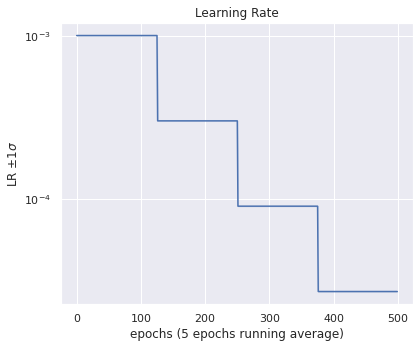

In [28]:
# plot the MAE
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))
lr_data = {'lr_mean': np.mean(training_data['lr'][-1,:,:], axis=1),
           'lr_std': np.std(training_data['lr'][-1,:,:], axis=1)
          }
sns.lineplot(x=np.arange(lr_data['lr_mean'].shape[0]),
             y=lr_data['lr_mean'],
             color='C0',
             ax=ax
            )
ax.fill_between(x=np.arange(lr_data['lr_mean'].shape[0]),
                y1=lr_data['lr_mean'] + lr_data['lr_std'],
                y2=lr_data['lr_mean'] - lr_data['lr_std'],
                color='C0',
                alpha=0.15
               )

ax.set(title='Learning Rate', xlabel=f'epochs ({int(0.01 * fit_data["epochs"]):d} epochs running average)', ylabel=f'LR $\pm 1\sigma$', yscale='log')
savefig('fc_lr', fig, show=True)

Finally we compute the predictions on the test set and evaluate the model (only the model with largest sample size for simplicity):

In [29]:
# print the evaluations
print('Loss:')
print(f'  training:   {np.mean(evaluations["training"][-1,:,:], axis=-1)[0]:.3f} ± {np.std(evaluations["training"][-1,:,:], axis=-1)[0]:.3f}')
print(f'  validation: {np.mean(evaluations["validation"][-1,:,:], axis=-1)[0]:.3f} ± {np.std(evaluations["validation"][-1,:,:], axis=-1)[0]:.3f}')
print(f'  test:       {np.mean(evaluations["test"][-1,:,:], axis=-1)[0]:.3f} ± {np.std(evaluations["test"][-1,:,:], axis=-1)[0]:.3f}')
print('MSE:')
print(f'  training:   {np.mean(evaluations["training"][-1,:,:], axis=-1)[1]:.3f} ± {np.std(evaluations["training"][-1,:,:], axis=-1)[1]:.3f}')
print(f'  validation: {np.mean(evaluations["validation"][-1,:,:], axis=-1)[1]:.3f} ± {np.std(evaluations["validation"][-1,:,:], axis=-1)[1]:.3f}')
print(f'  test:       {np.mean(evaluations["test"][-1,:,:], axis=-1)[1]:.3f} ± {np.std(evaluations["test"][-1,:,:], axis=-1)[1]:.3f}')
print('MAE:')
print(f'  training:   {np.mean(evaluations["training"][-1,:,:], axis=-1)[2]:.3f} ± {np.std(evaluations["training"][-1,:,:], axis=-1)[2]:.3f}')
print(f'  validation: {np.mean(evaluations["validation"][-1,:,:], axis=-1)[2]:.3f} ± {np.std(evaluations["validation"][-1,:,:], axis=-1)[2]:.3f}')
print(f'  test:       {np.mean(evaluations["test"][-1,:,:], axis=-1)[2]:.3f} ± {np.std(evaluations["test"][-1,:,:], axis=-1)[2]:.3f}')

Loss:
  training:   0.458 ± 0.016
  validation: 0.354 ± 0.006
  test:       0.541 ± 0.015
MSE:
  training:   0.441 ± 0.013
  validation: 0.336 ± 0.007
  test:       0.524 ± 0.012
MAE:
  training:   0.547 ± 0.008
  validation: 0.490 ± 0.003
  test:       0.613 ± 0.015


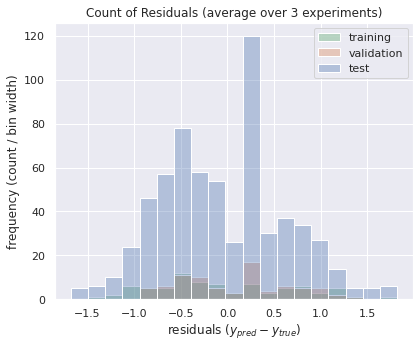

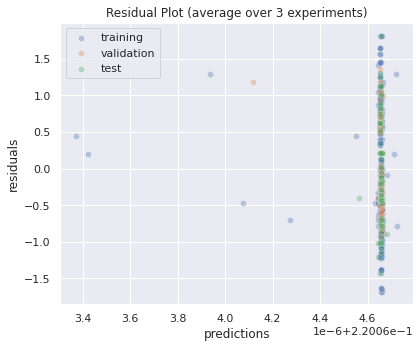

In [30]:
# compute the residuals
train_y = train.map(lambda x, y: y)
val_y   = val.map(lambda x, y: y)
test_y  = test.map(lambda x, y: y)

real_values = {'training':   list(train_y.as_numpy_iterator()),
               'validation': list(val_y.as_numpy_iterator()),
               'test':       list(test_y.as_numpy_iterator())
              }
residuals = {k: np.mean(predictions[k][-1,:,:], axis=-1) - v for k, v in real_values.items()}

# plot the univariate distribution of the residuals
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))

sns.histplot(residuals,
             stat='count',
             alpha=0.35,
             ax=ax
            )
ax.set(title=f'Count of Residuals (average over {stat_data["average"]:d} experiments)',
       xlabel='residuals ($y_{pred} - y_{true}$)',
       ylabel='frequency (count / bin width)'
      )
ax.legend(['training', 'validation', 'test'])

savefig('fc_hist', fig, show=True)

# plot the residuals plot
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))

sns.scatterplot(x=np.mean(predictions['training'][-1,:,:], axis=-1),
                y=residuals['training'],
                alpha=0.35,
                ax=ax
               )
sns.scatterplot(x=np.mean(predictions['validation'][-1,:,:], axis=-1),
                y=residuals['validation'],
                alpha=0.35,
                ax=ax
               )
sns.scatterplot(x=np.mean(predictions['test'][-1,:,:], axis=-1),
                y=residuals['test'],
                alpha=0.35,
                ax=ax
               )
ax.set(title=f'Residual Plot (average over {stat_data["average"]:d} experiments)',
       xlabel='predictions',
       ylabel='residuals'
      )
ax.legend(['training', 'validation', 'test'])

savefig('fc_resplot', fig, show=True)

Finally we plot the learning curve:

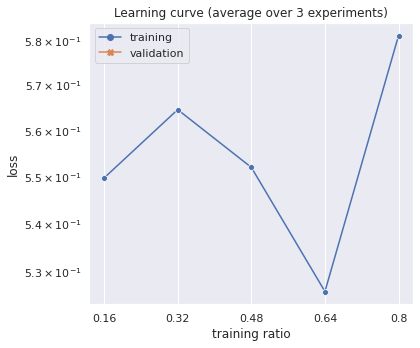

In [31]:
# compute the average loss
lc_data = {'training':   np.min(np.mean(training_data['train_loss'], axis=-1), axis=-1),
           'validation': np.min(np.mean(training_data['val_loss'], axis=-1), axis=-1)
          }

# plot the data
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))

sns.lineplot(data=lc_data,
             markers=True,
             dashes=False,
             ax=ax
            )

ax.set(title=f'Learning curve (average over {stat_data["average"]:d} experiments)',
       xlabel='training ratio',
       ylabel='loss',
       yscale='log',
       xticks=range(len(sample_sizes)),
       xticklabels=[round(s * train_ratio, 2) for s in sample_sizes]
      )

savefig('fc_lc', fig, show=True)

Eventually we save everything to file for persistency:

In [32]:
training_data_json = {k: v.tolist() for k, v in training_data.items()}

with open(os.path.join(now_dir, 'training_data.json'), 'w') as f:
    json.dump(training_data_json, f)
    
evaluations_json = {k: v.tolist() for k, v in evaluations.items()}

with open(os.path.join(now_dir, 'evaluations.json'), 'w') as f:
    json.dump(evaluations_json, f)
    
predictions_json = {k: v.tolist() for k, v in predictions.items()}

with open(os.path.join(now_dir, 'predictions.json'), 'w') as f:
    json.dump(predictions_json, f)
    
residuals_json = {k: v.tolist() for k, v in residuals.items()}

with open(os.path.join(now_dir, 'residuals.json'), 'w') as f:
    json.dump(residuals_json, f)

In [33]:
with open(os.path.join(now_dir, 'model_data.json'), 'w') as f:
    json.dump(model_data, f)
    
with open(os.path.join(now_dir, 'fit_data.json'), 'w') as f:
    json.dump(fit_data, f)
    
with open(os.path.join(now_dir, 'stat_data.json'), 'w') as f:
    json.dump(stat_data, f)